In [77]:
df = pd.read_csv('../../../data/preprocessed/feature_selection_by_multi_corr_final_data_60feature.csv')
X = df.drop(['price_per_m2'], axis=1)
y = df['price_per_m2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [79]:
sample_weights = np.where(
    y_train > 1000, 
    1.0,  # Normal weight for higher-priced properties
    0.3   # Reduced weight for low-priced properties
)

In [80]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    max_depth=6,               # Constrain depth
    learning_rate=0.05,
    subsample=0.7,             # Data subsampling
    colsample_bytree=0.6,      # Feature subsampling
    reg_alpha=0.5,             # L1 regularization
    reg_lambda=1.0,            # L2 regularization
    gamma=0.1,                 # Minimum loss reduction
    min_child_weight=10,       # Require more samples in leaves
    random_state=42,
    n_jobs=-1
)

In [81]:
xgb_model.fit(
    X_train,
    y_train_log,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test_log)],
    verbose=20
)

[0]	validation_0-rmse:1.36041
[20]	validation_0-rmse:0.77639
[40]	validation_0-rmse:0.54885
[60]	validation_0-rmse:0.44814
[80]	validation_0-rmse:0.38779
[100]	validation_0-rmse:0.34924
[120]	validation_0-rmse:0.32049
[140]	validation_0-rmse:0.30045
[160]	validation_0-rmse:0.28527
[180]	validation_0-rmse:0.27244
[200]	validation_0-rmse:0.26186
[220]	validation_0-rmse:0.25421
[240]	validation_0-rmse:0.24589
[260]	validation_0-rmse:0.23938
[280]	validation_0-rmse:0.23274
[300]	validation_0-rmse:0.22810
[320]	validation_0-rmse:0.22385
[340]	validation_0-rmse:0.21935
[360]	validation_0-rmse:0.21486
[380]	validation_0-rmse:0.21143
[400]	validation_0-rmse:0.20852
[420]	validation_0-rmse:0.20508
[440]	validation_0-rmse:0.20258
[460]	validation_0-rmse:0.20086
[480]	validation_0-rmse:0.19977
[499]	validation_0-rmse:0.19905


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [82]:
y_pred_test_log = xgb_model.predict(X_test)
y_pred_test = np.expm1(y_pred_test_log)
y_pred_train = np.expm1(xgb_model.predict(X_train))

In [83]:
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100
    return r2, mae, mape

r2_train, mae_train, mape_train = calculate_metrics(y_train, y_pred_train)
r2_test, mae_test, mape_test = calculate_metrics(y_test, y_pred_test)

In [84]:
print("="*50)
print(f"Train R²: {r2_train:.4f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Train MAPE: {mape_train:.2f}%")
print("-"*50)
print(f"Test R²: {r2_test:.4f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Test MAPE: {mape_test:.2f}%")
print(f"Test Avg Price: {y_test.mean():.2f}")
print("="*50)


Train R²: 0.9775
Train MAE: 184.00
Train MAPE: 14.26%
--------------------------------------------------
Test R²: 0.9742
Test MAE: 200.37
Test MAPE: 15.08%
Test Avg Price: 1936.11


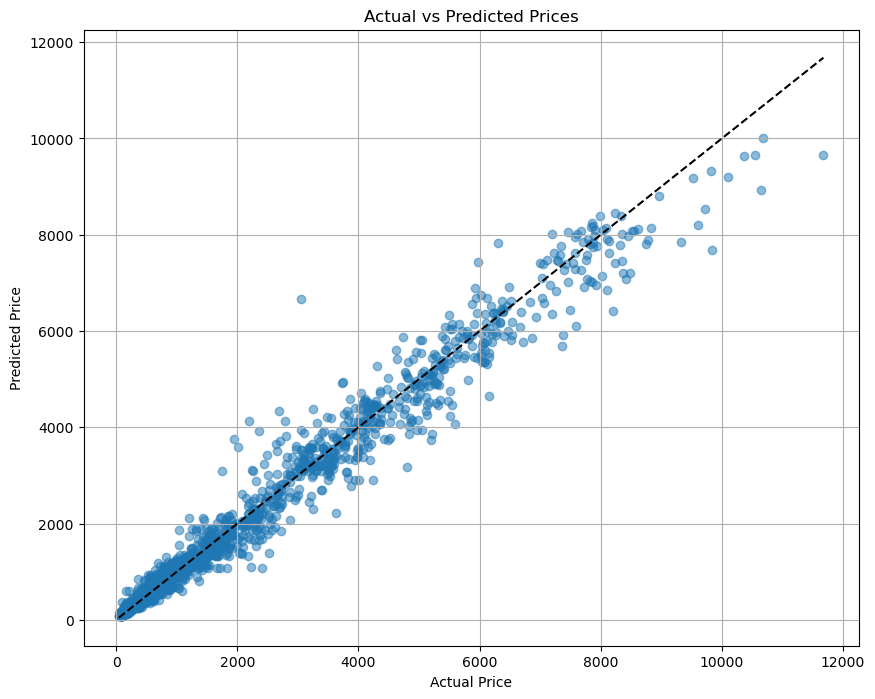

In [85]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.grid(True)

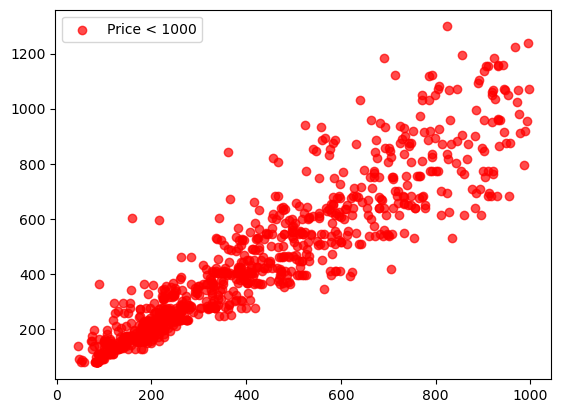

In [86]:
low_price_mask = y_test < 1000
plt.scatter(
    y_test[low_price_mask], 
    y_pred_test[low_price_mask], 
    c='red', 
    alpha=0.7,
    label='Price < 1000'
)
plt.legend()
plt.savefig("xgb_actual_vs_predicted.png")
plt.show()

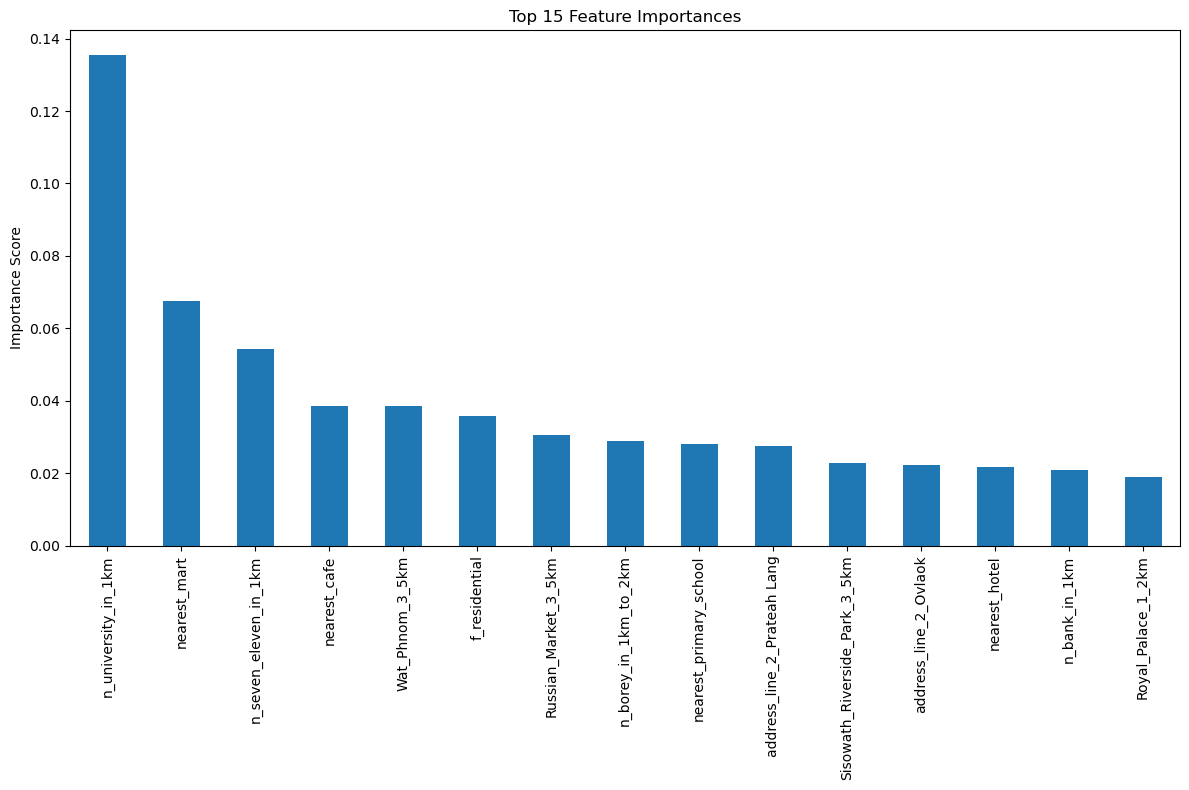

In [87]:
feature_importance = pd.Series(
    xgb_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
feature_importance.head(15).plot.bar()
plt.title('Top 15 Feature Importances')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.savefig("xgb_feature_importances.png")
plt.show()